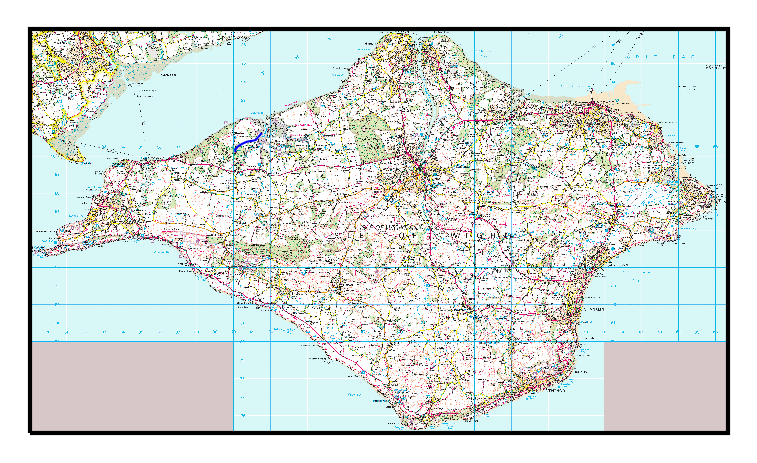

In [3]:
import networkx as nx
import json
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import LineString

solent_itn_json = "solent_itn.json"
with open(solent_itn_json, "r") as f:
    solent_itn=json.load(f)

g = nx.Graph()
road_links = solent_itn['roadlinks']
for link in road_links:
    g.add_edge(road_links[link]['start'], road_links[link]['end'], fid = link, weight = road_links[link]['length'])



isle_background = "raster-50k_2724246.tif"

path = ['osgb4000000026142773', 'osgb4000000026142774', 'osgb5000005143367011', 'osgb5000005143367009']

links = [] # this list will be used to populate the feature id (fid) column
geom  = [] # this list will be used to populate the geometry column

first_node = path[0]
for node in path[1:]:
    link_fid = g.edges[first_node, node]['fid']
    links.append(link_fid)
    geom.append(LineString(road_links[link_fid]['coords']))
    first_node = node

shortest_path_gpd = gpd.GeoDataFrame({"fid": links, "geometry": geom})



background = rasterio.open(str(isle_background))
back_array = background.read(1)
palette = np.array([value for key, value in background.colormap(1).items()])
background_image = palette[back_array]
bounds = background.bounds
extent = [bounds.left, bounds.right, bounds.bottom,  bounds.top]
display_extent = [bounds.left+200, bounds.right-200, bounds.bottom+600, bounds.top-600]

fig = plt.figure(figsize=(3,3), dpi=300)
ax = fig.add_subplot(1,1,1, projection=ccrs.OSGB())

ax.imshow(background_image, origin="upper", extent=extent, zorder=0)
shortest_path_gpd.plot(ax=ax, edgecolor="blue", linewidth=0.5, zorder=2)

ax.set_extent(display_extent, crs=ccrs.OSGB())
